# Classical Markowitz Portfolio Optimization

This notebook implements the **classical mean–variance optimization** (Markowitz model) 
as a **baseline** for comparison against quantum approaches.

### Contents

1. **Problem Setup**

   - Expected returns vector $μ$
   - Covariance matrix $Σ$
   - Risk-aversion parameter $λ$

2. **Optimization (cvxpy)**

   - Minimize: $−μᵀw + λ wᵀΣw$
   - Constraints: $Σ w = 1$, $w ≥ 0$

3. **Results & Visualization**

   - Optimal allocation
   - Bar chart and pie chart of weights

### Notes

- Provides a classical baseline to validate quantum results
- If Markowitz solution matches Fractional VQE, correctness is confirmed
- Extendable to real data (Yahoo Finance)

In [16]:
import numpy as np
import cvxpy as cp
import os
import matplotlib.pyplot as plt

np.random.seed(0)

In [17]:
# Problem setup
mu = np.array([0.10, 0.20, 0.15, 0.12])  # Expected returns
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
])

n_assets = len(mu)
lam = 0.5  # risk-aversion parameter

# Define optimization variables
w = cp.Variable(n_assets)

# Objective: -mu^T w + lam * w^T Sigma w
objective = cp.Minimize(-mu @ w + lam * cp.quad_form(w, Sigma))

# Constraints: weights sum to 1, non-negative
constraints = [cp.sum(w) == 1, w >= 0]

# Solve
prob = cp.Problem(objective, constraints)
prob.solve()

w_opt = w.value
print("Optimal weights (Markowitz):")
for i, wi in enumerate(w_opt):
    print(f"Asset {i+1}: {wi*100:.2f}%")

Optimal weights (Markowitz):
Asset 1: -0.00%
Asset 2: 100.00%
Asset 3: -0.00%
Asset 4: -0.00%


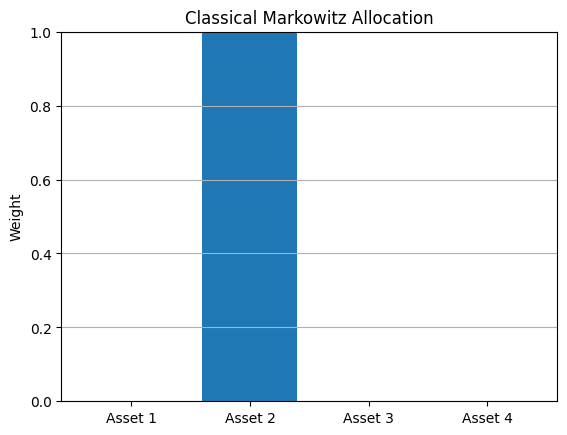

In [18]:
# Bar chart
# Clean numerical noise, renormalise then plot
w_opt = np.where(w_opt < 0, 0, w_opt)
w_opt = w_opt / np.sum(w_opt)
plt.figure()
plt.bar([f"Asset {i+1}" for i in range(n_assets)], w_opt)
plt.ylabel("Weight")
plt.ylim(0, 1)
plt.title("Classical Markowitz Allocation")
plt.grid(axis="y")

# Save to images/
os.makedirs("images", exist_ok=True)
plt.savefig("images/Markowitz_Bar.png", dpi=200, bbox_inches="tight")
plt.show()

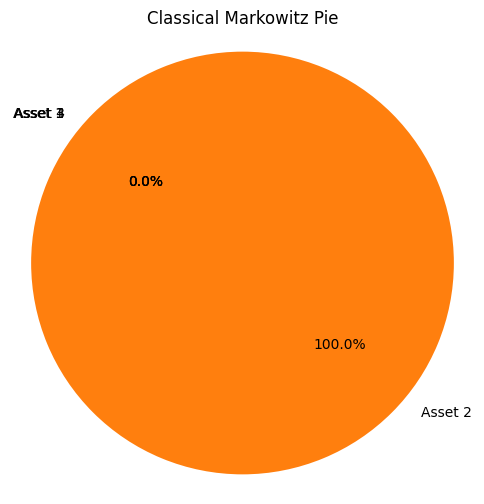

In [19]:
# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    w_opt,
    labels=[f"Asset {i+1}" for i in range(n_assets)],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Classical Markowitz Pie")
plt.axis("equal")
plt.savefig("images/Markowitz_Pie.png", dpi=200, bbox_inches="tight")
plt.show()